In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/' # were output shapefile, river and mizuRoute network topology will be saved
regions = ['3'] # 3 North America
riv_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
cat_path = '/project/rpp-kshook/Model_Output/HDMA/processed/'
riv_file_template = 'hdma_global_stream.shp'
cat_file_template = 'hdma_global_catch_v2_*000000.gpkg'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.hdma_read_file  (regions,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template)

# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                            cat=cat,\
                            cat_cols={'id':'hruid', 'hillslope':'hillslope', 'area': 'area_org'},\
                            network = 'hdma')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:538: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:539: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-1 From Fraser River

In [6]:
# set the case name
prefix = 'Fraser_hdma_'

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=[3044523]) # segment that is aimed to make the subbasin for

<AxesSubplot:>

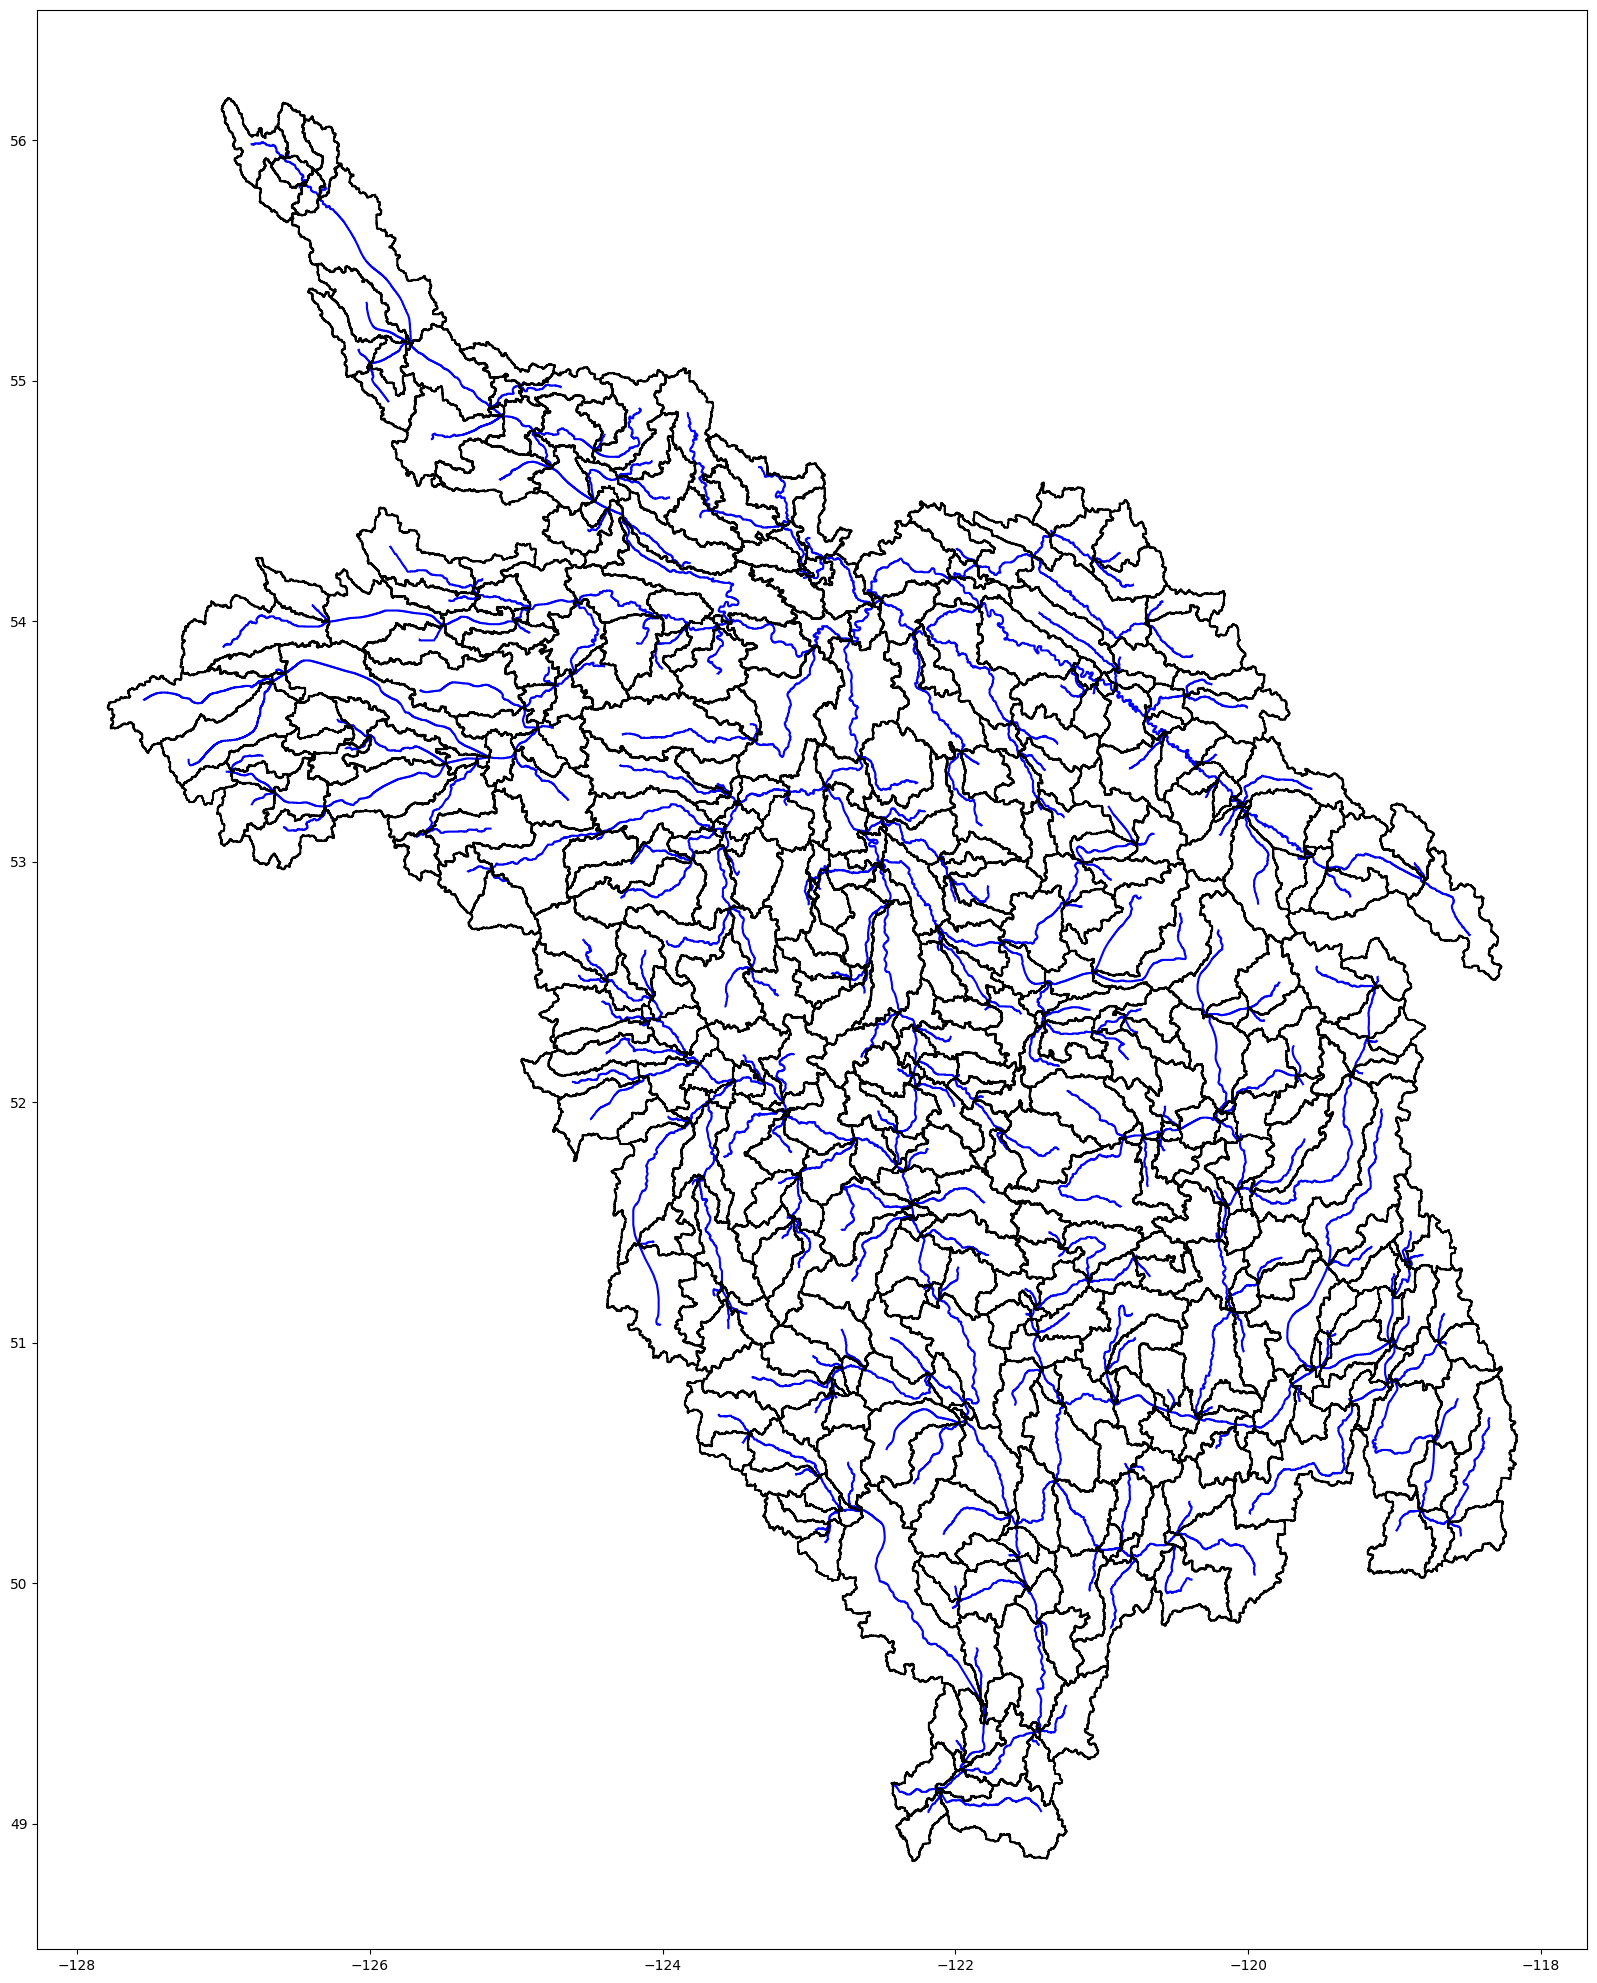

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [9]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 491)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 483 484 485 486 487 488 489 490
Data variables: (12/21)
    BotElev     (n) float64 349.0 890.0 730.0 393.0 ... 29.0 10.0 6.0 6.0
    Length      (n) float64 2.271e+03 832.7 4.497e+03 ... 1.817e+04 3.967e+04
    OBJECTID    (n) int64 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999 -9999
    PFAF        (n) int64 3142614 3145364 3146992 ... 314171 31415 314133
    PFAF_CODE   (n) int64 314261400000 314536400000 ... 314133000000
    PF_TYPE     (n) int64 6 6 6 6 6 7 5 5 5 5 6 6 6 ... 2 2 2 2 2 2 2 2 2 2 2 2
    ...          ...
    start_y     (n) float64 50.64 52.51 53.07 51.46 ... 49.4 49.37 49.22 49.15
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    area_org    (n) float64 2.483e+08 2.487e+08 ... 2.243e+08 5.092e+08
    latitude    (n) float64 50.54 52.48 53.15 51.47 ... 49.39 49.29 49.15 49.18
    longitude   (n) float64 -119.9 -122.9 -119.5 -120.0 ... -121.7 -121.9 -122.2
    width       (n) float64 16.85 16.86 16.93 16.93 ... 469.0 470.0 479.2 481.4

## save

In [10]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')


# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [11]:
# set the case name
prefix = 'ALSASK_hdma_'

In [12]:
# load the info and the provience
trg_shp = gpd.read_file('./data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [13]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       shapefile=trg_provinces)

In [ ]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

<AxesSubplot:>

In [ ]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

In [ ]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [ ]:
# set the case name
prefix = 'stations_hdma_'

In [ ]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [3035173, 3037796, 3030143, 3039206],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [  51.11,  51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [ ]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



In [ ]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [ ]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
xr_ntopo

In [ ]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')